# Create Simulation



In [10]:
from IPython.parallel import Client


ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.

In [18]:

# Most Basic
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import math
from os import path
import sys
from datetime import datetime
from scipy.stats import norm
import scipy.stats as ss
import copy
import warnings
warnings.simplefilter('error')
import datetime

# Filter Specific Functionalities
from filterpy.kalman import UnscentedKalmanFilter
from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import MerweScaledSigmaPoints

# Gradient Based
import autograd.numpy as a_np
import autograd.scipy.stats as a_ss
from autograd import grad, multigrad_dict, elementwise_grad, jacobian

# Self Defined functions5
from DataMaker_New import dataCleaner_new
from ESN import EchoState
from Loss_diag_updateV import loss
from GenerateSimulatedData import make_simulated_data


# Generate Option Data

Shape of true_vol_mean is (10, 201)
Shape of gen_vol_obs is (10, 201, 10)
Shape of us is (10, 201)
Shape of ps is (10, 201)
Shape of rs is (1, 201)
Shape of Ts is (10,)
Shape of Ks is (10, 201, 10)
Shape of ys is (10, 201, 10)
smallest strike price is 1713.85
[=======100%=======] After Truncation
Shape of true_vol_mean is (10, 194)
Shape of gen_vol_obs is (10, 10)
Shape of us_ccd is (10, 194, 8)
Shape of ps is (10, 194)
Shape of rs is (1, 194)
Shape of Ts is (10,)
Shape of Ks is (10, 194, 10)
Shape of ys is (10, 194, 10)
Attached 167 train days; 1670 train observations
Attached 2 valid days; 20 valid observations
Attached 25 test days; 250 test observations


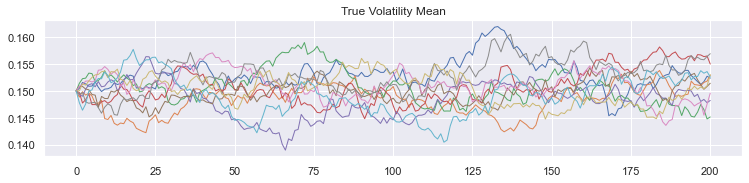

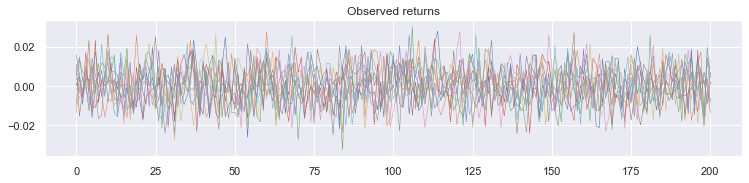

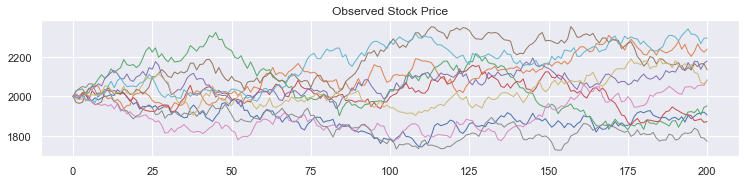

In [19]:
u_dim = 8
topK = 10
n_scenario = 10
np.random.seed(1234)
train_list, valid_list, test_list, true_vol = make_simulated_data(n_scenarios= n_scenario, n_steps=200 ,true_vol_std=0.01, topK=topK, random_state=1234, init_price=2000, u_dim=u_dim)

train_dates = list(train_list[0].keys())
valid_dates = list(valid_list[0].keys())
test_dates = list(test_list[0].keys())
num_train_day = max(train_dates)-min(train_dates)+1
num_valid_day = max(valid_dates)-min(valid_dates)+1
num_test_day = max(test_dates)-min(test_dates)+1
num_train_obs = num_train_day*topK 
num_valid_obs = num_valid_day*topK
num_test_obs = num_test_day*topK 

print("Attached {} train days; {} train observations".format(num_train_day, num_train_obs))
print("Attached {} valid days; {} valid observations".format(num_valid_day, num_valid_obs))
print("Attached {} test days; {} test observations".format(num_test_day, num_test_obs))

## Prepare Functions

In [20]:
# Define transition Dynamics
# Positional requirement, no real effect, will be replaced by ESN and BS defined further down
def fx(x, dt):
    return x*dt
def hx(x):
    return x

def sigmoid(x):
    return np.divide(1, 1+np.exp(-x))


def ESNf(theta_now, dt, **fx_args):
    """
    :params theta_now theta_t
    
    **fx_args
    :params G reservoir transition matrix
    :params G_in input translation matrix
    :params b reservoir bias vector
    :params u_quad_now u_t^2
    """
    G = fx_args["G"]
    G_in = fx_args["G_in"]
    b = fx_args["b"]
    u_quad_now = fx_args["u_quad_now"]
    theta_next = sigmoid(np.matmul(G, theta_now) + np.matmul(G_in, u_quad_now) + b)
    return theta_next
    

def BSf(theta_t, **hx_args):
    """
    :params theta_t current state vector
    
    **hx_args
    :params p_t current asset price
    :params r_t current asset price
    :params K_t strike price, 1d vector
    :params T_t maturity time, 1d vector
    """
    p_t = hx_args["p_t"]
    r_t = hx_args["r_t"]
    K_t = hx_args["K_t"]
    T_t = hx_args["T_t"]
    
    volatility_std = np.average(theta_t)
    volatility_var = np.power(volatility_std, 2)
    
    dividor = np.sqrt(volatility_var * T_t)
    d_pls = (np.log(p_t/K_t) + np.multiply(r_t+volatility_var/2, T_t)) / dividor
    d_mns = (np.log(p_t/K_t) + np.multiply(r_t-volatility_var/2, T_t)) / dividor
    y_t = np.multiply(p_t, norm.cdf(d_pls)) - np.multiply(np.multiply(K_t, np.exp(-r_t*T_t)), norm.cdf(d_mns))
    return y_t

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

def getCoverage(mean, std, truth):
    check_points = np.arange(5, 100, 5) / 100
    
    
    samples = np.random.normal( mean, std, (50, 100) )
    
    coverage_for_1_observation = []
    for check_point in check_points:
        lower = np.quantile(samples, 0.5-check_point/2, axis=1 )
        upper = np.quantile(samples, 0.5+check_point/2, axis=1 ) 
        coverage_for_1_observation.append( float(np.count_nonzero( np.logical_and( lower < truth , truth < upper ) ) / 50 ) )
    return coverage_for_1_observation

# SLEEP!

In [42]:
np.random.seed(1234)
gradient = grad(loss)


forward_k = 20

error_for_all_scenario = []
best_itr_for_all_scenario = []
best_train_itr_for_all_scenario = []
best_valid_itr_for_all_scenario= []
params_for_all_scenario = []
ms_s_for_all_scenario = []
Cs_s_for_all_scenario = []
pred_Cs_for_all_scenario = []

train_pred_ms_for_all_scenario = []
pred_ms_for_all_scenario = []


theta_dim = 64
print("theta_dim = {}".format(theta_dim))   

for scenario_idx in range(n_scenario):
    best_valid_error = 999
    best_valid_itr = 0
    
    train_data = train_list[scenario_idx]
    valid_data = valid_list[scenario_idx]
    test_data = test_list[scenario_idx]
    
    step = 0.01
    m_t_1 = [np.array([0]), np.array([0]), np.array([0]), np.array([0]), np.array([0])]
    v_t_1 = [np.array([0]), np.array([0]), np.array([0]), np.array([0]), np.array([0])]
    beta_1 = 0.9
    beta_2 = 0.999
    epsillon = 1e-8
    
    print("The {}th scenario".format(scenario_idx+1))
    alpha = 0.03
    connectivity = 0.4
    spectral_radius = 1.2
    bday_p_year = 252
    bias = -2.65

    v_scale = 4.0
    w = 0.0001

    # initialize ESN dynamics
    ESN = EchoState(theta_dim, u_dim, connectivity, spectral_radius, bias)
    ESN.G_in *= 2
    v = v_scale

    last_avg_error = 100
    best_itr = 0
    best_train_error = 100
    best_train_itr = 0
    
    #%%%%%% Error trajectories
    
    test_error_traj = []
    params_traj = []
    ms_s_traj = []
    Cs_s_traj = []
    
    train_pred_ms_traj = []
    pred_ms_traj = []
    pred_Cs_traj = []
    
    for em_itr in range(50):
        dt=1
        points = MerweScaledSigmaPoints(theta_dim, alpha=.001, beta=2., kappa=0)
        ukf = UnscentedKalmanFilter(dim_x=ESN.theta_dim, dim_z=topK, dt=1, fx=fx, hx=hx, points=points)
        ukf.x = np.ones(ESN.theta_dim)* 0.006 # initial state
        ukf.P *= 0.01 # initial uncertainty
        ukf.R = np.diag([v]*topK) # 1 standard
        ukf.Q = np.eye(theta_dim)*w

        ms = [ukf.x.copy()]
        Cs = [ukf.P.copy()]
        u_quad_s = []
        ps = []
        rs = []
        ys = []
        Ks = []
        us = []
        Ts = []

        all_days = sorted(list(train_data.keys()))
        for day in all_days:
            # get observable data
            ## Stock Wise and market wise data
            r_t = train_data[day]["risk ir"] 
            u_t = train_data[day]["return"].reshape([-1]) * math.sqrt(bday_p_year)
            p_t = train_data[day]["price"]

            ## Option wise data
            y_t = train_data[day]["option price"]
            K_t = train_data[day]["Strike"]
            T_t = train_data[day]["Exercise Time"]

            ukf.predict(fx = ESNf, G=ESN.G, G_in=ESN.G_in, b= ESN.b, u_quad_now=np.power(u_t,2))
            ukf.update(y_t, hx=BSf, p_t=p_t, r_t=r_t, K_t=K_t, T_t=T_t)
            ms.append(ukf.x_post.copy())
            Cs.append(ukf.P_post.copy())
            u_quad_s.append(np.power(u_t,2))
            us.append(u_t)
            ps.append(p_t)
            rs.append(r_t)
            ys.append(y_t)
            Ks.append(K_t)
            Ts.append(T_t)

        ms = np.array(ms)
        Cs = np.array(Cs)
        ms_s, Cs_s, _, cvs_s = ukf.rts_smoother(ms, Cs, fx=ESNf, G=ESN.G, G_in=ESN.G_in, b=ESN.b, u_s=us)


        params = [copy.copy(ESN.G), copy.copy(ESN.G_in), copy.copy(ESN.b), copy.copy(w), copy.copy(v)]

        
        try:
            curr_loss = loss(params,
                             ms_s, Cs_s, cvs_s,
                             u_quad_s,
                             ps, rs, Ks, Ts, ys,
                             num_train_obs,
                             reg=alpha)
            curr_grad = gradient(params,
                                 ms_s, Cs_s, cvs_s,
                                 u_quad_s,
                                 ps, rs, Ks, Ts, ys,
                                 num_train_obs,
                                 reg=alpha)

######################## Adam Optimizer ###########################
            
            m_t = [None, None, None, None, None]
            v_t = [None, None, None, None, None]
            m_t_hat = [None, None, None, None, None]
            v_t_hat = [None, None, None, None, None]

            m_t[0] = beta_1 * m_t_1[0] + (1-beta_1) * curr_grad[0]
            v_t[0] = beta_2 * v_t_1[0] + (1-beta_2) * (curr_grad[0] * curr_grad[0])
            m_t_hat[0] = m_t[0] / (1-beta_1 ** (em_itr+1))
            v_t_hat[0] = v_t[0] / (1-beta_2 ** (em_itr+1))
            params[0] -= step * m_t_hat[0] / (np.sqrt(v_t_hat[0]) + epsillon)

            m_t[1] = beta_1 * m_t_1[1] + (1-beta_1) * curr_grad[1]
            v_t[1] = beta_2 * v_t_1[1] + (1-beta_2) * (curr_grad[1] * curr_grad[1])
            m_t_hat[1] = m_t[1] / (1-beta_1 ** (em_itr+1))
            v_t_hat[1] = v_t[1] / (1-beta_2 ** (em_itr+1))
            params[1] -= step * m_t_hat[1] / (np.sqrt(v_t_hat[1]) + epsillon)

            m_t[2] = beta_1 * m_t_1[2] + (1-beta_1) * curr_grad[2]
            v_t[2] = beta_2 * v_t_1[2] + (1-beta_2) * (curr_grad[2] * curr_grad[2])
            m_t_hat[2] = m_t[2] / (1-beta_1 ** (em_itr+1))
            v_t_hat[2] = v_t[2] / (1-beta_2 ** (em_itr+1))
            params[2] -= step * m_t_hat[2] / (np.sqrt(v_t_hat[2]) + epsillon)
            
            m_t[3] = beta_1 * m_t_1[3] + (1-beta_1) * curr_grad[3]
            v_t[3] = beta_2 * v_t_1[3] + (1-beta_2) * (curr_grad[3] * curr_grad[3])
            m_t_hat[3] = m_t[3] / (1-beta_1 ** (em_itr+1))
            v_t_hat[3] = v_t[3] / (1-beta_2 ** (em_itr+1))
            params[3] -= step * m_t_hat[3] / (np.sqrt(v_t_hat[3]) + epsillon)

            m_t[4] = beta_1 * m_t_1[4] + (1-beta_1) * curr_grad[4]
            v_t[4] = beta_2 * v_t_1[4] + (1-beta_2) * (curr_grad[4] * curr_grad[4])
            m_t_hat[4] = m_t[4] / (1-beta_1 ** (em_itr+1))
            v_t_hat[4] = v_t[4] / (1-beta_2 ** (em_itr+1))
            params[4] -= step * m_t_hat[4] / (np.sqrt(v_t_hat[4]) + epsillon)

            m_t = m_t_1
            v_t = v_t_1

###################################################################

        except RuntimeWarning or LinAlgError or OverflowError or w <= 0:
            print("set w to 1e-6 ensure positive")
            pass

        ESN.G, ESN.G_in, ESN.b, _, __ = params
        w = max(0.000001, params[3][0]) # Change form arraybox back to scalar
        v = max(0.000001, params[4][0]) # Change form arraybox back to scalar

        
################################################################### Training Performance
        
        train_pred_ms = []
        train_errors = []
        np.delete(ms_s,0,0)
        np.delete(Cs_s,0,0)
        for i in range(0, len(ms_s)-1):

            ukf.predict(fx = ESNf,  G=ESN.G, G_in=ESN.G_in, b= ESN.b, u_quad_now=u_quad_s[i])
            train_pred_ms.append(np.average(ukf.x_prior))
            pred_price = BSf(ukf.x_prior, p_t=ps[i], r_t=rs[i], K_t=Ks[i], T_t=Ts[i])
            error = np.average(np.abs(ys[i]-pred_price) /ys[i])
            train_errors.append(error)
            ukf.update(ys[i], hx=BSf, p_t=ps[i], r_t=rs[i], K_t=Ks[i], T_t=Ts[i])
        
        train_pred_ms_traj.append(train_pred_ms)
        avg_train_error = np.average(train_errors)
################################################################### Validation Performance
        ukf.x = ms_s[-1]
        ukf.P = Cs_s[-1]
        valid_errors = []
        pred_ms = []
        pred_Cs = []
        
        all_valid_days = sorted(list(valid_data.keys()))
        for day in all_valid_days:
            # get observable data
            ## Stock Wise and market wise data
            r_t = valid_data[day]["risk ir"]
            u_t = valid_data[day]["return"].reshape([-1]) * math.sqrt(bday_p_year)
            p_t = valid_data[day]["price"]

            ## Option wise data
            y_t = valid_data[day]["option price"]
            K_t = valid_data[day]["Strike"]
            T_t = valid_data[day]["Exercise Time"]
            
            ukf.predict(fx = ESNf, G=ESN.G, G_in=ESN.G_in, b= ESN.b, u_quad_now=np.power(u_t,2))
            pred_ms.append(ukf.x_prior)
            pred_Cs.append(ukf.P_prior)
            pred_price = BSf(ukf.x_prior, p_t=p_t, r_t=r_t, K_t=K_t, T_t=T_t)
            error = np.average(np.abs(y_t-pred_price) /y_t)
            valid_errors.append(error)
            
            ukf.update(y_t, hx=BSf, p_t=p_t, r_t=r_t, K_t=K_t, T_t=T_t)
            
        avg_valid_error = np.average(valid_errors) 

################################################################### Testing Performance
        
        # forward K step prediction
        k_step_test_error = []

        test_k_step_pred_ms = {}
        test_k_step_pred_Cs = {}
        
        for k in range(1, min(forward_k+1, num_test_day+1)): 
            
            test_k_step_pred_ms[k] = []
            test_k_step_pred_Cs[k] = []
            
            test_errors = []            
            all_test_days = sorted(list(test_data.keys()))
            
            for idx in range(len(all_test_days) - k):
                
                ukf_pred = copy.deepcopy(ukf)
                
                # For loop for k predictions forward
                for shift in range(k) :
                    # get observable data
                    ## Stock Wise and market wise data
                    r_t = test_data[all_test_days[idx+shift]]["risk ir"]
                    u_t = test_data[all_test_days[idx+shift]]["return"].reshape([-1]) * math.sqrt(bday_p_year)
                    p_t = test_data[all_test_days[idx+shift]]["price"]

                    ## Option wise data
                    y_t = test_data[all_test_days[idx+shift]]["option price"]
                    K_t = test_data[all_test_days[idx+shift]]["Strike"]
                    T_t = test_data[all_test_days[idx+shift]]["Exercise Time"]

                    ukf_pred.predict(fx = ESNf, G=ESN.G, G_in=ESN.G_in, b= ESN.b, u_quad_now=np.power(u_t,2))
                    
                
                test_k_step_pred_ms[k].append(ukf_pred.x_prior)
                test_k_step_pred_Cs[k].append(ukf_pred.P_prior)
                
                
                pred_price = BSf(ukf_pred.x_prior, p_t=p_t, r_t=r_t, K_t=K_t, T_t=T_t)
                error = np.average(np.abs(y_t-pred_price) /y_t)
                test_errors.append(error)
                
                
                # shift base one step forward
                r_t = test_data[all_test_days[idx]]["risk ir"] 
                u_t = test_data[all_test_days[idx]]["return"].reshape([-1]) * math.sqrt(bday_p_year)
                p_t = test_data[all_test_days[idx]]["price"]

                ## Option wise data
                y_t = test_data[all_test_days[idx]]["option price"]
                K_t = test_data[all_test_days[idx]]["Strike"]
                T_t = test_data[all_test_days[idx]]["Exercise Time"]

                ukf.predict(fx = ESNf, G=ESN.G, G_in=ESN.G_in, b= ESN.b, u_quad_now=np.power(u_t,2))
                ukf.update(y_t, hx=BSf, p_t=p_t, r_t=r_t, K_t=K_t, T_t=T_t)
            
            if test_errors != []:
                avg_test_error = np.average(test_errors)
                k_step_test_error.append(avg_test_error)
            else:
                pass
            
            
################################################################### Show details
        print("EM Iter {} | Loss {:.4f} | Train Error {:.4f} | Val Error {:.4f} | Test 1-Error {:.4f} | Test max-Error {:.4f} |"  
              " Dyn var {:.2f} | Obs var {:.2f}".format(em_itr, curr_loss,
                                                        avg_train_error, avg_valid_error, k_step_test_error[0], k_step_test_error[-1],
                                                        w, v))
        
        # Get best validation itr
        if best_valid_error > avg_valid_error:
            best_valid_error = avg_valid_error
            best_valid_itr = em_itr
            if curr_loss > 5000:
                best_valid_itr -= 1
        
        if avg_valid_error - best_valid_error > 0.01:
            break
        
        if last_avg_error < avg_valid_error and em_itr-best_itr >= 10:
            pass 
        elif last_avg_error < avg_valid_error and em_itr-best_itr < 10:
            pass
        elif last_avg_error > avg_valid_error and em_itr-best_itr < 10:
            last_avg_error = avg_valid_error
            model_performance = avg_test_error
            best_itr = em_itr
            
        if best_train_error > avg_train_error and em_itr-best_train_itr < 10:
            best_train_error = avg_train_error
            best_train_itr = em_itr
        elif best_train_error < avg_train_error:
            step = 0.002
    
        test_error_traj.append(k_step_test_error)
        params_traj.append(copy.deepcopy(params))
        ms_s_traj.append(ms_s)
        Cs_s_traj.append(Cs_s)
        pred_ms_traj.append(test_k_step_pred_ms)
        pred_Cs_traj.append(test_k_step_pred_Cs)
    
    error_for_all_scenario.append(test_error_traj)
    best_itr_for_all_scenario.append(best_itr)
    best_train_itr_for_all_scenario.append(best_train_itr)
    best_valid_itr_for_all_scenario.append(best_valid_itr)
    params_for_all_scenario.append(params_traj)
    ms_s_for_all_scenario.append(ms_s_traj)
    Cs_s_for_all_scenario.append(Cs_s_traj)
    pred_ms_for_all_scenario.append(pred_ms_traj)
    pred_Cs_for_all_scenario.append(pred_Cs_traj)
    train_pred_ms_for_all_scenario.append(train_pred_ms_traj)
    
    print("best val error: {} at {}th iteration, Model Performance: {} | theta_dim = {}".format(last_avg_error,
                                                                                                best_itr,
                                                                                                model_performance,
                                                                                                theta_dim))
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

theta_dim = 64
The 1th scenario
EM Iter 0 | Loss 20273.1118 | Train Error 0.1002 | Val Error 0.0859 | Test 1-Error 0.1024 | Test max-Error 0.1015 | Dyn var 0.01 | Obs var 4.01
EM Iter 1 | Loss -241.9189 | Train Error 0.0845 | Val Error 0.0705 | Test 1-Error 0.0863 | Test max-Error 0.0890 | Dyn var 0.00 | Obs var 4.02
EM Iter 2 | Loss 290.9543 | Train Error 0.0731 | Val Error 0.0593 | Test 1-Error 0.0750 | Test max-Error 0.0757 | Dyn var 0.01 | Obs var 4.02
EM Iter 3 | Loss -246.5300 | Train Error 0.0559 | Val Error 0.0421 | Test 1-Error 0.0574 | Test max-Error 0.0626 | Dyn var 0.00 | Obs var 4.03
EM Iter 4 | Loss 110.3047 | Train Error 0.0443 | Val Error 0.0307 | Test 1-Error 0.0455 | Test max-Error 0.0484 | Dyn var 0.01 | Obs var 4.04
EM Iter 5 | Loss -260.3936 | Train Error 0.0299 | Val Error 0.0172 | Test 1-Error 0.0302 | Test max-Error 0.0341 | Dyn var 0.00 | Obs var 4.04
EM Iter 6 | Loss 30.5660 | Train Error 0.0224 | Val Error 0.0210 | Test 1-Error 0.0215 | Test max-Error 0.0223 

In [43]:
# best_valid_itr_for_all_scenario = [2,6,4,2,6,4,4,4,4,4,]
print(best_valid_itr_for_all_scenario)

[5, 16, 12, 7, 12, 7, 9, 12, 11, 9]


# PLOT RESULT

0.048374455100866076


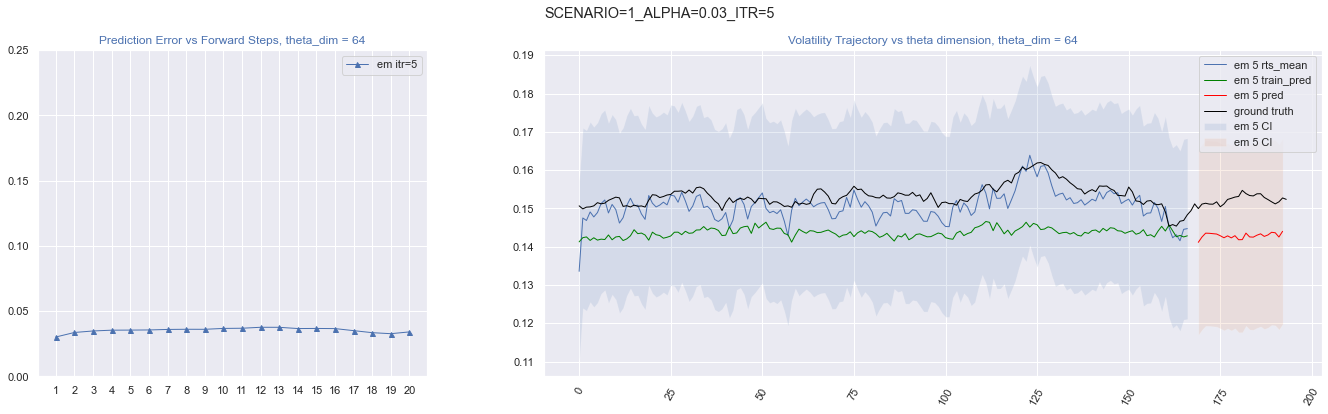

0.040617168128958936


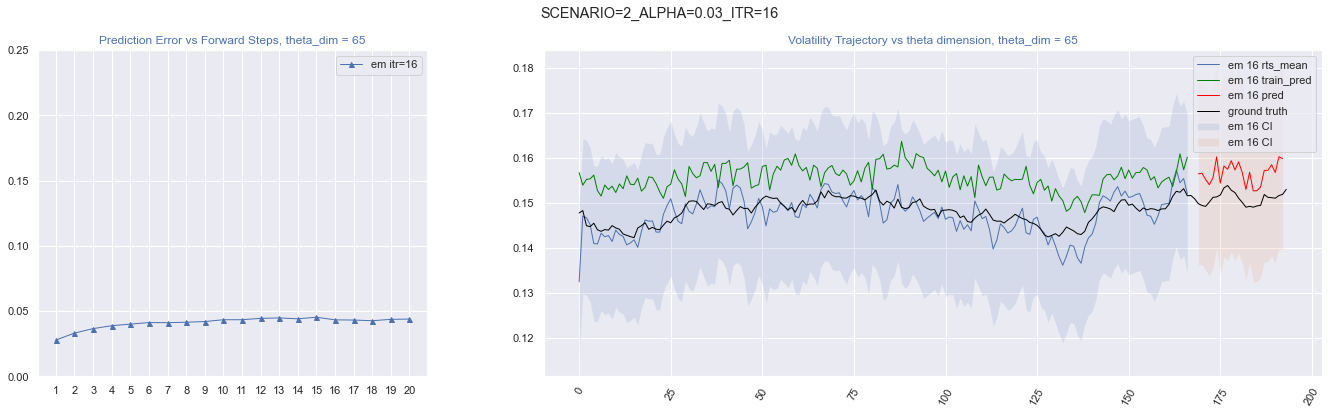

0.0339007027780906


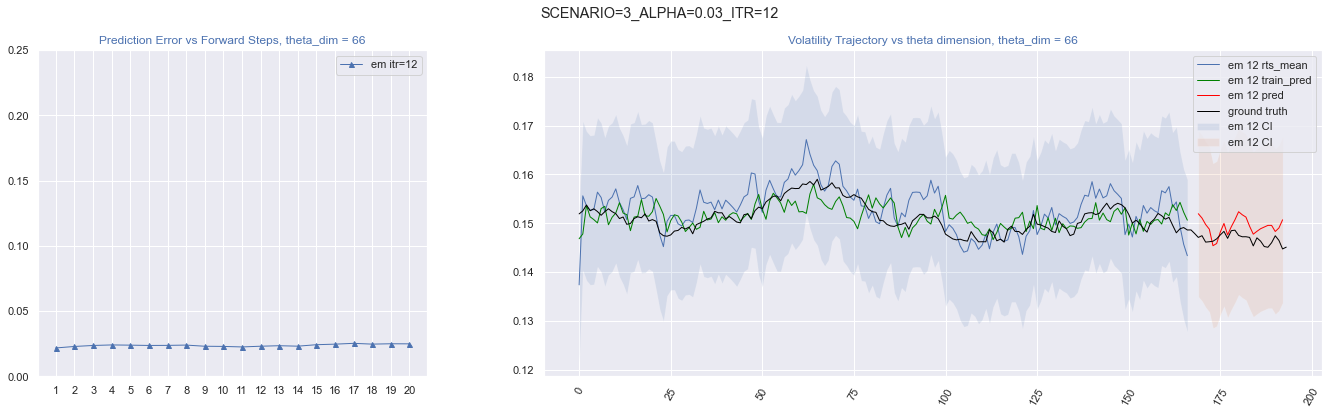

0.04901563653882046


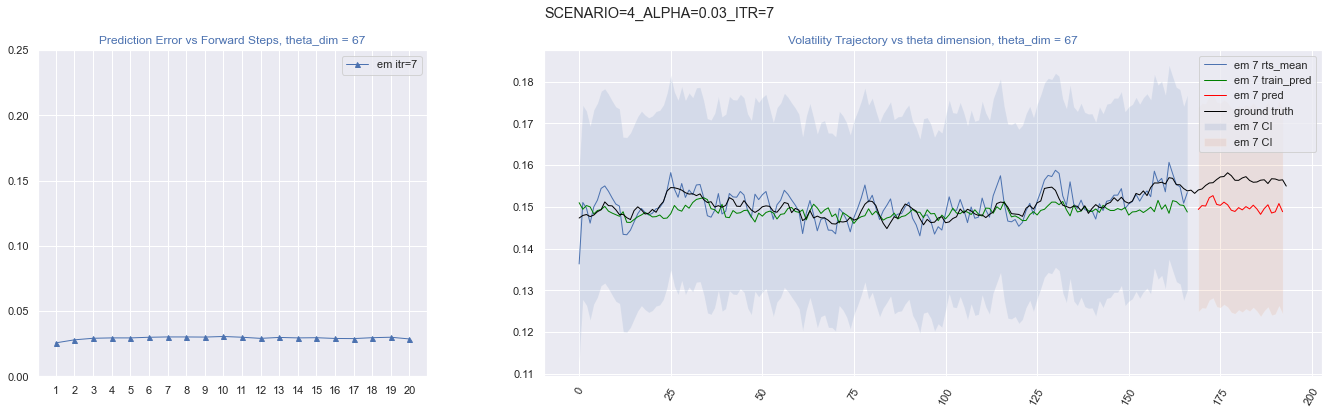

0.03361728652362628


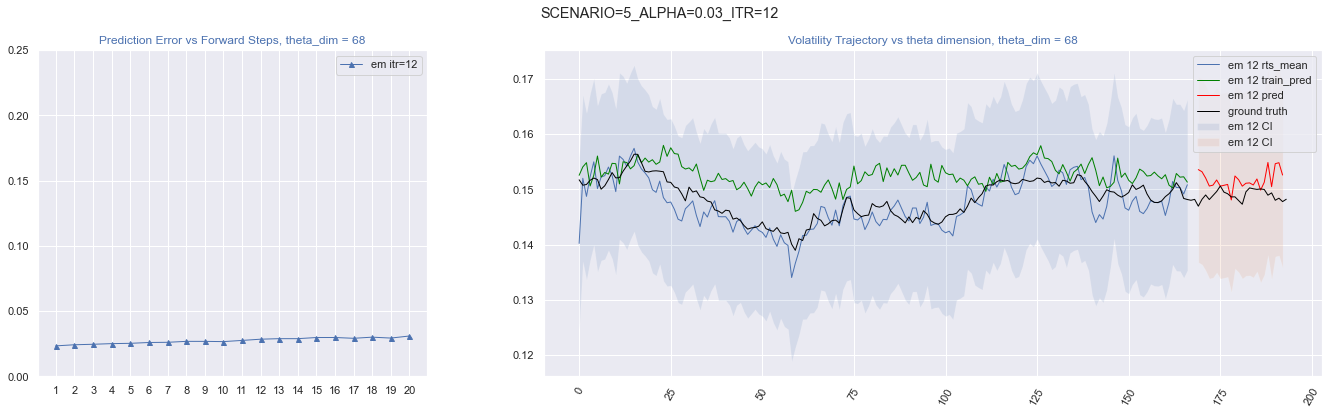

0.04896577147512193


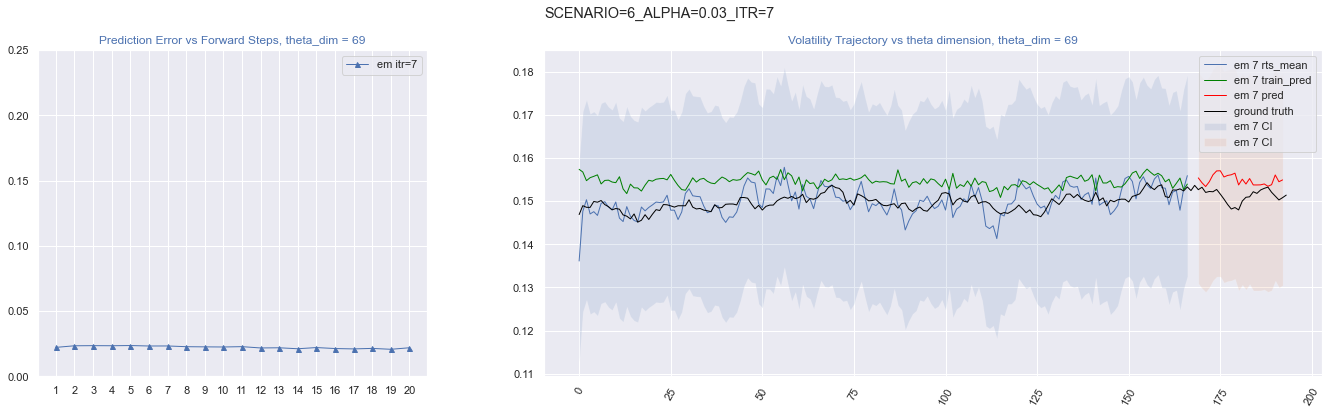

0.049607740706063164


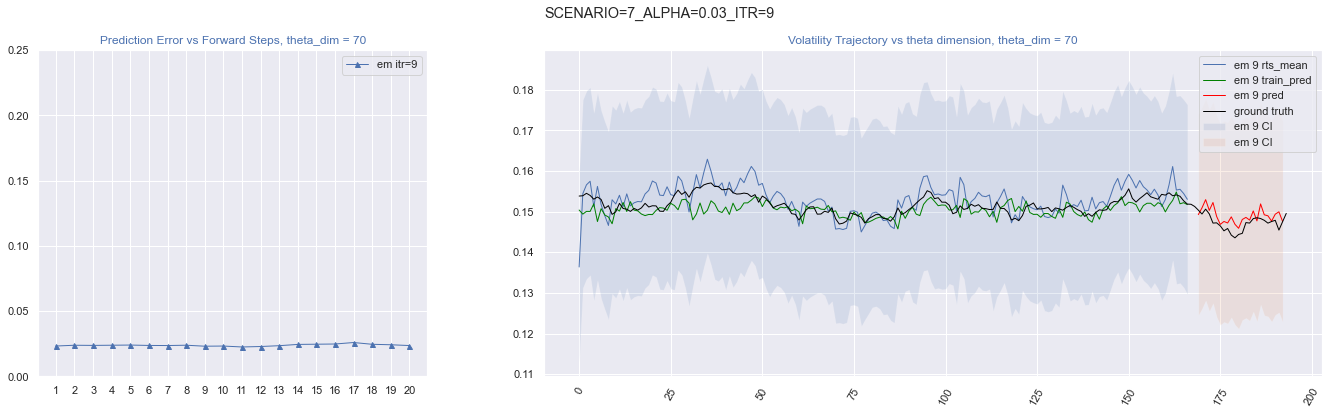

0.03312798738614148


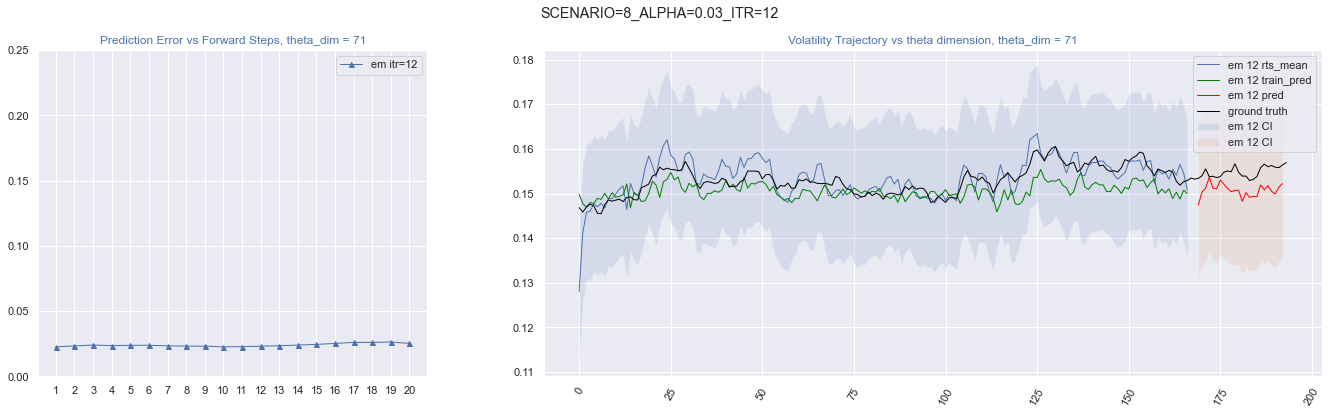

0.05056855165380386


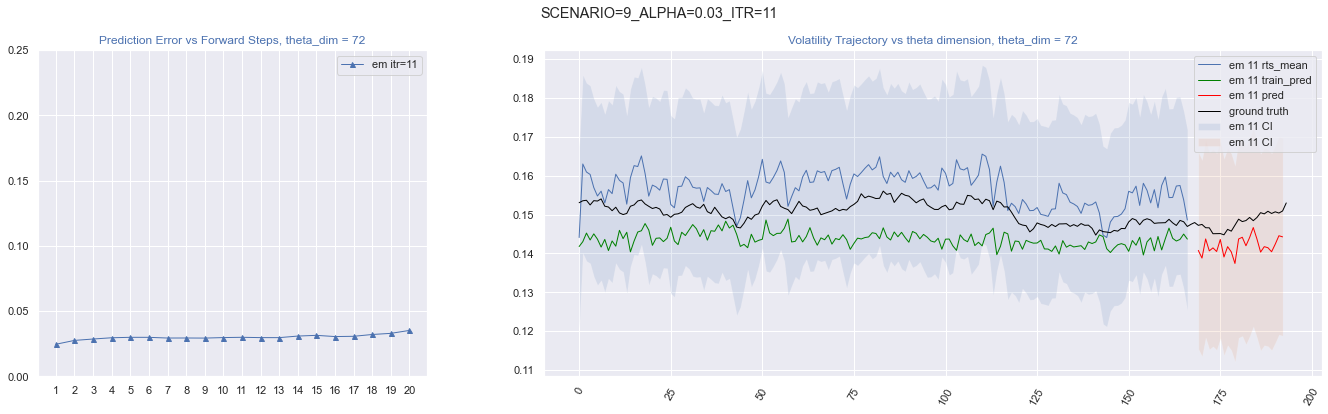

0.049738405181661116


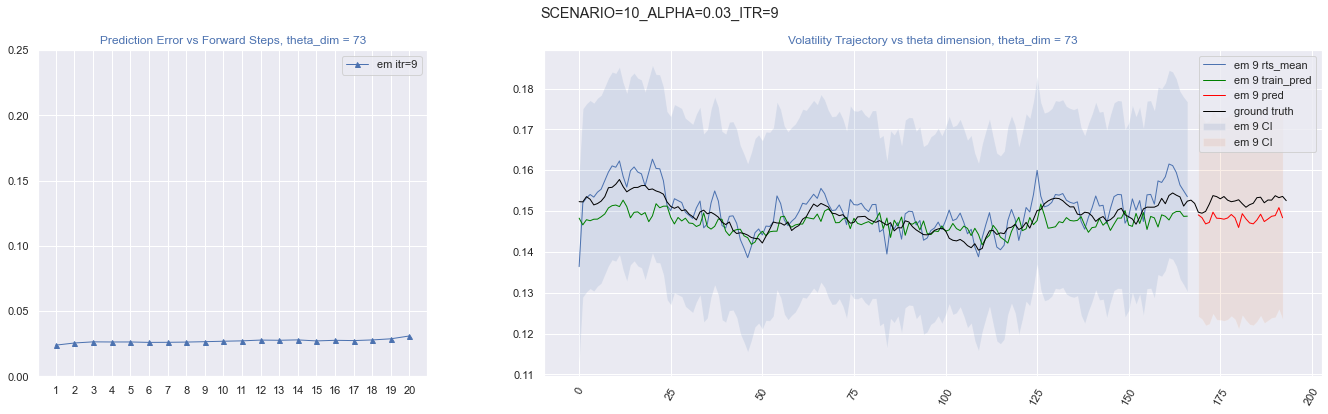

error = 0.0240
error = 0.0264
error = 0.0269
error = 0.0272
error = 0.0310


In [44]:
if len(error_for_all_scenario) == 0:
    error_for_all_scenario.append(test_error_traj)
    best_itr_for_all_scenario.append(best_itr)
    best_train_itr_for_all_scenario.append(best_train_itr)
    params_for_all_scenario.append(params_traj)
    ms_s_for_all_scenario.append(ms_s_traj)
    Cs_s_for_all_scenario.append(Cs_s_traj)
    pred_ms_for_all_scenario.append(pred_ms_traj)
    train_pred_ms_for_all_scenario.append(train_pred_ms_traj)
    print("just appended once")
    
warnings.simplefilter('error')


all_pred_days = sorted(list(valid_data.keys()) + list(test_data.keys()))
for k in range(len(ms_s_for_all_scenario)):

    
    mean_iteration = best_valid_itr_for_all_scenario[k]
    iterations = range(mean_iteration, mean_iteration+1) 
    
    sns.set()
    fig = plt.figure(figsize=(23, 6))
    spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[1, 2], height_ratios=[1])
    title = "SCENARIO={}_ALPHA={}_ITR={}".format(k+1, alpha, mean_iteration)
    fig.suptitle(title)
    

    # forward steps
    a = fig.add_subplot(spec[0, 0])
    xlabel = list(range(1, forward_k+1))
    plt.xticks(xlabel)
    a.set_ylim(0.0, 0.25)
    a.set_title('Prediction Error vs Forward Steps, theta_dim = {}'.format(k+theta_dim), color='C0')
    for i in iterations:
        show = error_for_all_scenario[k][i] 
        a.plot([i+1 for i in range(forward_k)], show, marker='^', markersize= 5, linewidth=1)
    a.legend(["em itr={}".format(i) for i in iterations])
    
    
    # volatility trajectory
    b = fig.add_subplot(spec[0, 1])
    averager = np.ones(theta_dim) / (theta_dim)
    b.set_title('Volatility Trajectory vs theta dimension, theta_dim = {}'.format(k+theta_dim), color='C0')
    legend = []
    opaque = 0.9/(len(iterations)+1)
    for i in iterations:
        smoothed_volatility_mean = np.average(ms_s_for_all_scenario[k][i], axis=1) #i+1
        smoothed_volatility_std = np.array( [math.sqrt(np.matmul(np.matmul(averager.T, _), averager.T)) for _ in Cs_s_for_all_scenario[k][i]]) #i+1
        smoothed_volatility_ci_upper = smoothed_volatility_mean + 2*smoothed_volatility_std
        smoothed_volatility_ci_lower = smoothed_volatility_mean - 2*smoothed_volatility_std

        predicted_volatility_mean = np.average(pred_ms_for_all_scenario[k][i][1], axis=1)
        predicted_volatility_std = np.array( [math.sqrt(np.matmul(np.matmul(averager.T, _), averager.T)) for _ in pred_Cs_for_all_scenario[k][i][1] ])
        predicted_volatility_ci_upper = predicted_volatility_mean + 2*predicted_volatility_std
        predicted_volatility_ci_lower = predicted_volatility_mean - 2*predicted_volatility_std

        train_predicted_volatility_mean = train_pred_ms_for_all_scenario[k][i]        
        
        b.plot(all_days, smoothed_volatility_mean[1:], linewidth=1, label="em {} rts_mean".format(i), )
        b.plot(all_days, train_predicted_volatility_mean, linewidth=1, color = "green", label="em {} train_pred".format(i),)
        b.plot(list(test_data.keys())[:-1], predicted_volatility_mean, linewidth=1, color = "red", label="em {} pred".format(i))
        b.plot(range(len(true_vol[k])) , true_vol[k], linewidth=1, color = "black", label="ground truth" )
        
        b.fill_between(all_days, smoothed_volatility_ci_upper[1:], smoothed_volatility_ci_lower[1:], alpha = 0.3*opaque*(1+i-mean_iteration), label="em {} CI".format(i))
        b.fill_between(list(test_data.keys())[:-1], predicted_volatility_ci_upper, predicted_volatility_ci_lower, alpha = 0.3*opaque*(1+i-mean_iteration), label="em {} CI".format(i))
        print(predicted_volatility_ci_upper[1]-predicted_volatility_ci_lower[1])

    b.legend()
    plt.xticks(rotation=60)
    plt.show()
    
#     plt.savefig("./output_fig/Final.jpg")

print("error = {:.4f}".format(show[0]))
print("error = {:.4f}".format(show[4]))
print("error = {:.4f}".format(show[9]))
print("error = {:.4f}".format(show[14]))
print("error = {:.4f}".format(show[19]))

# VERIFY COVERAGE

In [45]:
def getCoverage(mean, std, truth):
    check_points = np.arange(5, 100, 5) / 100
    
    nums = 200
    
    samples = np.random.normal( mean, std, (nums, 100) )
    
    coverage_for_1_observation = []
    for check_point in check_points:
        lower = np.quantile(samples, 0.5-check_point/2, axis=1 )
        upper = np.quantile(samples, 0.5+check_point/2, axis=1 ) 
        coverage_for_1_observation.append( float(np.count_nonzero( np.logical_and( lower < truth , truth < upper ) ) / nums ) )
    return coverage_for_1_observation

In [46]:
test_start_idx = min(test_data.keys())
test_end_idx = max(test_data.keys())

averager = np.ones(theta_dim) / (theta_dim)

cov_for_all_k = []
for k in range(1, forward_k+1):
    cov_for_one_k = []
    
    for scenario_idx in range(0,n_scenario):
        if best_valid_itr_for_all_scenario[scenario_idx] > 0:
       
            target_itr = best_valid_itr_for_all_scenario[scenario_idx]
            test_prediction_results_ms = pred_ms_for_all_scenario[scenario_idx][target_itr][k]
            test_prediction_results_Cs = pred_Cs_for_all_scenario[scenario_idx][target_itr][k]

            cov_for_one_scenario = []
            for coverage_obs_idx in range(len(test_prediction_results_ms)):
                idx_in_test_data = coverage_obs_idx+test_start_idx+k-1
                ground_truth = test_list[scenario_idx][idx_in_test_data]['true vol']

                this_m = test_prediction_results_ms[coverage_obs_idx]
                this_C = test_prediction_results_Cs[coverage_obs_idx]

                coverage_predicted_mean = np.mean(this_m)
                coverage_predicted_std = math.sqrt(np.matmul(np.matmul(averager.T, this_C), averager.T))
                cov_for_one_scenario.append( getCoverage(coverage_predicted_mean, coverage_predicted_std, ground_truth) )
            cov_for_one_scenario = np.mean(np.array(cov_for_one_scenario), axis=0)

            cov_for_one_k.append(cov_for_one_scenario)
    cov_for_one_k = np.mean(np.array(cov_for_one_k), axis=0)
    cov_for_all_k.append(cov_for_one_k)

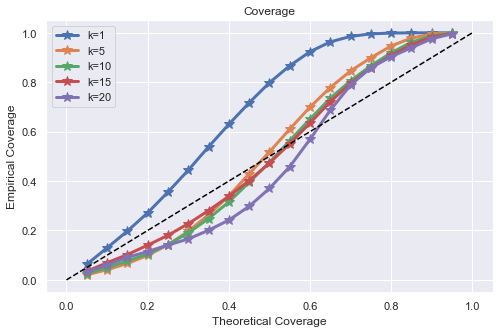

In [62]:
import matplotlib.lines as lines

check_points = np.arange(5, 100, 5) / 100
care = [0, 4, 9, 14, 19]

fig = plt.figure(figsize=(8,5))
plt.title("Coverage")
for i in care:
    plt.plot( check_points, cov_for_all_k[i] , marker="*", markersize=10,label="k={}".format(i+1), linewidth = 3)
plt.plot( [0,1], [0,1] , linestyle="--", color="black")
plt.legend()
plt.xlabel("Theoretical Coverage")
plt.ylabel("Empirical Coverage")
plt.savefig("./output_fig/coverage/theta64_alpha3e-2_step1e-2.jpg")


In [64]:
print(np.array(cov_for_all_k))

[[0.06335417 0.12958333 0.19752083 0.27141667 0.3554375  0.44395833
  0.53852083 0.6296875  0.71670833 0.79804167 0.86639583 0.92345833
  0.96325    0.9855     0.99564583 0.999      0.999875   1.
  1.        ]
 [0.03069565 0.0661087  0.11052174 0.16215217 0.2233913  0.29508696
  0.37654348 0.46197826 0.55063043 0.64       0.72804348 0.80726087
  0.87528261 0.92695652 0.96458696 0.98656522 0.99673913 0.99958696
  1.        ]
 [0.02325    0.04920455 0.07868182 0.118      0.16779545 0.23252273
  0.30870455 0.38906818 0.47952273 0.56897727 0.65806818 0.74522727
  0.823      0.88677273 0.93536364 0.97075    0.99168182 0.99870455
  0.99993182]
 [0.02159524 0.04347619 0.07007143 0.10295238 0.1482619  0.20521429
  0.27609524 0.35788095 0.44802381 0.53761905 0.6277381  0.71619048
  0.79383333 0.86004762 0.91528571 0.95759524 0.98497619 0.99630952
  0.99964286]
 [0.0206     0.041075   0.06655    0.099175   0.141975   0.19665
  0.263425   0.339925   0.429125   0.518      0.609925   0.699525
  0.7